# Analysis of Evolution of the Americans with Disability Act and its Impact on Americans with Disabilities in the United States

## by Joanne Lauer, Georgetown University McCourt School of Public Policy
### December 16, 2021
### words

In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
from pathlib import Path # used to read in form directories
import os
import warnings
warnings.filterwarnings("ignore")


In [2]:
# I downloaded the latest excel file available on census.gov and read it into a Data Frame
df20171 = pd.read_excel('2017_CPS/table-1.xlsx')

In [3]:
# The file is in such a poor format that it would take far too much time to format.
# Unfortunately the CPS is not available in an API at this time
print(df20171.head)

<bound method NDFrame.head of     Table 1 . Workers by Detailed Occupation1 and Disability Status, Number and Age Group, Median Age, Median Earnings of Full-time Year-round Workers,  and Percentage Working Full-time, Year-round: 2017  \
0    Universe:  Civilian, non-institutionalized, em...                                                                                                                                                        
1    Table with column headings in rows 5 through 7...                                                                                                                                                        
2    [Columns D through G are persons, columns H an...                                                                                                                                                        
3                                                  NaN                                                                                        

In [4]:
# Moving on to the Bureau of Labor and Statistics
nilfwd65=pd.read_excel("~/Fall2021Final/BLS_data/nilfwd65.xlsx")
print(nilfwd65)

   Labor Force Statistics from the Current Population Survey  \
0                                 Original Data Value          
1                                                 NaN          
2                                          Series Id:          
3                             Not Seasonally Adjusted          
4                                       Series title:          
5                                 Labor force status:          
6                                       Type of data:          
7                                                Age:          
8                                              Years:          
9                                                 NaN          
10                                               Year          
11                                               2011          
12                                               2012          
13                                               2013          
14                                      

In [5]:
# This data is a bit better and should be able to be used to do some initial work
print(type(nilfwd65))
print(nilfwd65.head)

<class 'pandas.core.frame.DataFrame'>
<bound method NDFrame.head of    Labor Force Statistics from the Current Population Survey  \
0                                 Original Data Value          
1                                                 NaN          
2                                          Series Id:          
3                             Not Seasonally Adjusted          
4                                       Series title:          
5                                 Labor force status:          
6                                       Type of data:          
7                                                Age:          
8                                              Years:          
9                                                 NaN          
10                                               Year          
11                                               2011          
12                                               2012          
13                                  

In [6]:
# drop the first 10 rows of data from the data frame as it is not needed and reset index
nilfwd65 = nilfwd65.drop(nilfwd65.index[0:10])
nilfwd65 = nilfwd65.reset_index()
print(nilfwd65.head)                          

<bound method NDFrame.head of     index Labor Force Statistics from the Current Population Survey  \
0      10                                               Year          
1      11                                               2011          
2      12                                               2012          
3      13                                               2013          
4      14                                               2014          
5      15                                               2015          
6      16                                               2016          
7      17                                               2017          
8      18                                               2018          
9      19                                               2019          
10     20                                               2020          
11     21                                               2021          

   Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4

In [7]:
# update the columns to use the month names as the column names and remove the duplicate column entry of month name
nilfwd65.columns = nilfwd65.iloc[0]
print(nilfwd65.columns)
print(nilfwd65)
nilfwd65 = nilfwd65[1:]

print(nilfwd65.columns)

Index([    10, 'Year',  'Jan',  'Feb',  'Mar',  'Apr',  'May',  'Jun',  'Jul',
        'Aug',  'Sep',  'Oct',  'Nov',  'Dec'],
      dtype='object', name=0)
0   10  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep  \
0   10  Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep   
1   11  2011  11441  11421  11524  11478  11399  11474  11499  11412  11547   
2   12  2012  11636  11650  11879  11930  11855  12058  11758  11853  12234   
3   13  2013  12054  12145  12324  12297  12236  12186  12232  12110  12156   
4   14  2014  12449  12541  12510  12470  12590  12610  12624  12656  12653   
5   15  2015  12800  12802  12953  12905  13077  13042  13074  12992  13172   
6   16  2016  12723  12610  12943  13010  13120  13302  13306  13358  13417   
7   17  2017  13319  13234  13618  13574  13495  13623  13458  13652  13617   
8   18  2018  13471  13518  13700  13685  13818  13924  13633  13429  13547   
9   19  2019  13681  13674  13709  14104  14024  1431

In [8]:
#drop the extra column
nilfwd65 = nilfwd65.drop(columns=nilfwd65.columns[0])
print(nilfwd65)

0   Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep  \
1   2011  11441  11421  11524  11478  11399  11474  11499  11412  11547   
2   2012  11636  11650  11879  11930  11855  12058  11758  11853  12234   
3   2013  12054  12145  12324  12297  12236  12186  12232  12110  12156   
4   2014  12449  12541  12510  12470  12590  12610  12624  12656  12653   
5   2015  12800  12802  12953  12905  13077  13042  13074  12992  13172   
6   2016  12723  12610  12943  13010  13120  13302  13306  13358  13417   
7   2017  13319  13234  13618  13574  13495  13623  13458  13652  13617   
8   2018  13471  13518  13700  13685  13818  13924  13633  13429  13547   
9   2019  13681  13674  13709  14104  14024  14318  13820  13843  13969   
10  2020  14263  14434  14344  14124  14096  13837  13435  13625  13752   
11  2021  13991  14079  14039  14031  14384  14663  14555  14435  14362   

0     Oct    Nov    Dec  
1   11360  11521  11529  
2   12144  12228  12185  
3   12224  12290  124

In [9]:
#replace the missing December 2021 data with a 0
nilfwd65.fillna(0)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1,2011,11441,11421,11524,11478,11399,11474,11499,11412,11547,11360,11521,11529
2,2012,11636,11650,11879,11930,11855,12058,11758,11853,12234,12144,12228,12185
3,2013,12054,12145,12324,12297,12236,12186,12232,12110,12156,12224,12290,12410
4,2014,12449,12541,12510,12470,12590,12610,12624,12656,12653,12719,12826,12848
5,2015,12800,12802,12953,12905,13077,13042,13074,12992,13172,13182,12865,12897
6,2016,12723,12610,12943,13010,13120,13302,13306,13358,13417,13357,13208,13312
7,2017,13319,13234,13618,13574,13495,13623,13458,13652,13617,13590,13548,13580
8,2018,13471,13518,13700,13685,13818,13924,13633,13429,13547,13559,13735,13843
9,2019,13681,13674,13709,14104,14024,14318,13820,13843,13969,13802,14229,14312
10,2020,14263,14434,14344,14124,14096,13837,13435,13625,13752,13578,13956,13938


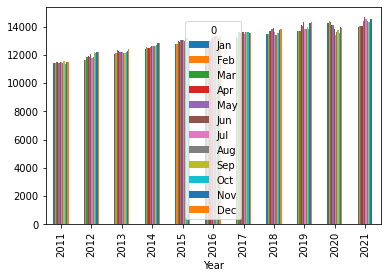

In [10]:
ax1=nilfwd65.plot(x="Year",
              y= ["Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec" ], kind="bar")



In [11]:
#read in file
ewd1664m=pd.read_excel("~/Fall2021Final/BLS_data/ewd1664m.xlsx")
print(ewd1664m)

   Labor Force Statistics from the Current Population Survey  \
0                                 Original Data Value          
1                                                 NaN          
2                                          Series Id:          
3                             Not Seasonally Adjusted          
4                                       Series title:          
5                                 Labor force status:          
6                                       Type of data:          
7                                                Age:          
8                                                Sex:          
9                                              Years:          
10                                                NaN          
11                                               Year          
12                                             2011.0          
13                                             2012.0          
14                                      

In [12]:
# drop the first 11 rows of data from the data frame as it is not needed and reset index
ewd1664m = ewd1664m.drop(ewd1664m.index[0:11])
ewd1664m = ewd1664m.reset_index()
print(ewd1664m.head)
type(ewd1664m)                         

<bound method NDFrame.head of     index Labor Force Statistics from the Current Population Survey  \
0      11                                               Year          
1      12                                             2011.0          
2      13                                             2012.0          
3      14                                             2013.0          
4      15                                             2014.0          
5      16                                             2015.0          
6      17                                             2016.0          
7      18                                             2017.0          
8      19                                             2018.0          
9      20                                             2019.0          
10     21                                             2020.0          
11     22                                             2021.0          

   Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4

pandas.core.frame.DataFrame

In [13]:
# create empty list 
ewd1664m_col = []
# write line 0 of df to list
ewd1664m_col = ewd1664m.iloc[0]
# use list to update column names
ewd1664m.columns = ewd1664m_col
list(ewd1664m.columns)
type(ewd1664m)

pandas.core.frame.DataFrame

In [14]:
#Update year to be an int
ewd1664m = ewd1664m.astype({11:int})
print(ewd1664m)
type(ewd1664m)

0   11    Year     Jan     Feb     Mar     Apr     May     Jun     Jul  \
0   11    Year     Jan     Feb     Mar     Apr     May     Jun     Jul   
1   12  2011.0  2106.0  2085.0  2196.0  2172.0  2218.0  2252.0  2215.0   
2   13  2012.0  2103.0  2006.0  2073.0  2163.0  2225.0  2215.0  2289.0   
3   14  2013.0  2322.0  2365.0  2290.0  2312.0  2216.0  2204.0  2240.0   
4   15  2014.0  1903.0  2042.0  2095.0  2128.0  2175.0  2140.0  2222.0   
5   16  2015.0  2220.0  2321.0  2306.0  2221.0  2335.0  2402.0  2265.0   
6   17  2016.0  2074.0  2122.0  2233.0  2329.0  2517.0  2507.0  2534.0   
7   18  2017.0  2181.0  2298.0  2430.0  2352.0  2457.0  2503.0  2572.0   
8   19  2018.0  2337.0  2488.0  2624.0  2474.0  2362.0  2391.0  2343.0   
9   20  2019.0  2387.0  2519.0  2623.0  2522.0  2514.0  2472.0  2402.0   
10  21  2020.0  2408.0  2483.0  2442.0  2096.0  2249.0  2244.0  2256.0   
11  22  2021.0  2237.0  2166.0  2226.0  2302.0  2304.0  2561.0  2587.0   

0      Aug     Sep     Oct     Nov   

pandas.core.frame.DataFrame

In [15]:
# update Column 0 
ewd1664m.rename(columns={11:"Type"}, inplace=True)

In [16]:
# add column to contain the table info id
Type = [1,1,1,1,1,1,1,1,1,1,1,1]
ewd1664m["Type"]=(Type)
print(ewd1664m)

0   Type    Year     Jan     Feb     Mar     Apr     May     Jun     Jul  \
0      1    Year     Jan     Feb     Mar     Apr     May     Jun     Jul   
1      1  2011.0  2106.0  2085.0  2196.0  2172.0  2218.0  2252.0  2215.0   
2      1  2012.0  2103.0  2006.0  2073.0  2163.0  2225.0  2215.0  2289.0   
3      1  2013.0  2322.0  2365.0  2290.0  2312.0  2216.0  2204.0  2240.0   
4      1  2014.0  1903.0  2042.0  2095.0  2128.0  2175.0  2140.0  2222.0   
5      1  2015.0  2220.0  2321.0  2306.0  2221.0  2335.0  2402.0  2265.0   
6      1  2016.0  2074.0  2122.0  2233.0  2329.0  2517.0  2507.0  2534.0   
7      1  2017.0  2181.0  2298.0  2430.0  2352.0  2457.0  2503.0  2572.0   
8      1  2018.0  2337.0  2488.0  2624.0  2474.0  2362.0  2391.0  2343.0   
9      1  2019.0  2387.0  2519.0  2623.0  2522.0  2514.0  2472.0  2402.0   
10     1  2020.0  2408.0  2483.0  2442.0  2096.0  2249.0  2244.0  2256.0   
11     1  2021.0  2237.0  2166.0  2226.0  2302.0  2304.0  2561.0  2587.0   

0      Aug 

In [17]:
#drop extra row of months
ewd1664m = ewd1664m.drop(labels=0, axis=0)

In [18]:
#replace the missing December 2021 data with a 0
ewd1664m = ewd1664m.fillna(0)


In [19]:
#Update year to be an int
ewd1664m = ewd1664m.astype({"Year":int})


In [20]:
# Add value for Sex 0 for male and 1 for female
sex = [0,0,0,0,0,0,0,0,0,0,0,]
ewd1664m["Sex"] = sex


In [21]:
print(ewd1664m)

0   Type  Year     Jan     Feb     Mar     Apr     May     Jun     Jul  \
1      1  2011  2106.0  2085.0  2196.0  2172.0  2218.0  2252.0  2215.0   
2      1  2012  2103.0  2006.0  2073.0  2163.0  2225.0  2215.0  2289.0   
3      1  2013  2322.0  2365.0  2290.0  2312.0  2216.0  2204.0  2240.0   
4      1  2014  1903.0  2042.0  2095.0  2128.0  2175.0  2140.0  2222.0   
5      1  2015  2220.0  2321.0  2306.0  2221.0  2335.0  2402.0  2265.0   
6      1  2016  2074.0  2122.0  2233.0  2329.0  2517.0  2507.0  2534.0   
7      1  2017  2181.0  2298.0  2430.0  2352.0  2457.0  2503.0  2572.0   
8      1  2018  2337.0  2488.0  2624.0  2474.0  2362.0  2391.0  2343.0   
9      1  2019  2387.0  2519.0  2623.0  2522.0  2514.0  2472.0  2402.0   
10     1  2020  2408.0  2483.0  2442.0  2096.0  2249.0  2244.0  2256.0   
11     1  2021  2237.0  2166.0  2226.0  2302.0  2304.0  2561.0  2587.0   

0      Aug     Sep     Oct     Nov     Dec  Sex  
1   2253.0  2135.0  2262.0  2223.0  2165.0    0  
2   2326.0 

In [22]:
#read in file
ewd1664w=pd.read_excel("~/Fall2021Final/BLS_data/ewd1664w.xlsx")
print(ewd1664w)

   Labor Force Statistics from the Current Population Survey  \
0                                 Original Data Value          
1                                                 NaN          
2                                          Series Id:          
3                             Not Seasonally Adjusted          
4                                       Series title:          
5                                 Labor force status:          
6                                       Type of data:          
7                                                Age:          
8                                                Sex:          
9                                              Years:          
10                                                NaN          
11                                               Year          
12                                             2011.0          
13                                             2012.0          
14                                      

In [23]:
# drop the first 10 rows of data from the data frame as it is not needed and reset index
ewd1664w = ewd1664w.drop(ewd1664w.index[0:11])
ewd1664w = ewd1664w.reset_index()
        

In [24]:
# create empty list 
ewd1664w_col = []
# write line 0 of df to list
ewd1664w_col = ewd1664w.iloc[0]
# use list to update column nmes
ewd1664w.columns = ewd1664w_col


In [25]:
# update Column 0 
ewd1664w.rename(columns={11:"Type"}, inplace=True)

In [26]:
# add column to contain the table info id
Type = [2,2,2,2,2,2,2,2,2,2,2,2]
ewd1664w["Type"]=(Type)

In [27]:
#drop extra row of months
ewd1664w = ewd1664w.drop(labels=0, axis=0)

In [28]:
#replace the missing December 2021 data with a 0
ewd1664w = ewd1664w.fillna(0)
#Update year to be an int
ewd1664m.astype({"Year":int})
print(ewd1664m)


0   Type  Year     Jan     Feb     Mar     Apr     May     Jun     Jul  \
1      1  2011  2106.0  2085.0  2196.0  2172.0  2218.0  2252.0  2215.0   
2      1  2012  2103.0  2006.0  2073.0  2163.0  2225.0  2215.0  2289.0   
3      1  2013  2322.0  2365.0  2290.0  2312.0  2216.0  2204.0  2240.0   
4      1  2014  1903.0  2042.0  2095.0  2128.0  2175.0  2140.0  2222.0   
5      1  2015  2220.0  2321.0  2306.0  2221.0  2335.0  2402.0  2265.0   
6      1  2016  2074.0  2122.0  2233.0  2329.0  2517.0  2507.0  2534.0   
7      1  2017  2181.0  2298.0  2430.0  2352.0  2457.0  2503.0  2572.0   
8      1  2018  2337.0  2488.0  2624.0  2474.0  2362.0  2391.0  2343.0   
9      1  2019  2387.0  2519.0  2623.0  2522.0  2514.0  2472.0  2402.0   
10     1  2020  2408.0  2483.0  2442.0  2096.0  2249.0  2244.0  2256.0   
11     1  2021  2237.0  2166.0  2226.0  2302.0  2304.0  2561.0  2587.0   

0      Aug     Sep     Oct     Nov     Dec  Sex  
1   2253.0  2135.0  2262.0  2223.0  2165.0    0  
2   2326.0 

In [29]:
# Add value for Sex 0 for male and 1 for female
sex = [1,1,1,1,1,1,1,1,1,1,1]
ewd1664w["Sex"] = sex

In [30]:
print(ewd1664w)

0   Type    Year     Jan     Feb     Mar     Apr     May     Jun     Jul  \
1      2  2011.0  1839.0  1834.0  1876.0  1890.0  1919.0  1838.0  1816.0   
2      2  2012.0  1903.0  1843.0  1913.0  1964.0  1964.0  1929.0  1817.0   
3      2  2013.0  1851.0  1910.0  1974.0  1943.0  1949.0  1846.0  1778.0   
4      2  2014.0  1761.0  1762.0  1827.0  1782.0  1801.0  1794.0  1844.0   
5      2  2015.0  1904.0  1925.0  2053.0  2026.0  2071.0  2069.0  1970.0   
6      2  2016.0  1990.0  1853.0  2049.0  2097.0  1989.0  1998.0  1910.0   
7      2  2017.0  2053.0  2111.0  2102.0  2157.0  2279.0  2216.0  2147.0   
8      2  2018.0  2108.0  2135.0  2321.0  2256.0  2225.0  2127.0  2081.0   
9      2  2019.0  2156.0  2130.0  2250.0  2249.0  2238.0  2305.0  2232.0   
10     2  2020.0  2220.0  2236.0  2330.0  1731.0  1790.0  1908.0  1807.0   
11     2  2021.0  2042.0  2119.0  2214.0  2314.0  2373.0  2485.0  2325.0   

0      Aug     Sep     Oct     Nov     Dec  Sex  
1   1821.0  1897.0  1960.0  1893.0  1

In [31]:
#read in file
ewnd1664w=pd.read_excel("~/Fall2021Final/BLS_data/ewnd1664w.xlsx")
print(ewnd1664w)

   Labor Force Statistics from the Current Population Survey  \
0                                 Original Data Value          
1                                                 NaN          
2                                          Series Id:          
3                             Not Seasonally Adjusted          
4                                       Series title:          
5                                 Labor force status:          
6                                       Type of data:          
7                                                Age:          
8                                                Sex:          
9                                              Years:          
10                                                NaN          
11                                               Year          
12                                             2011.0          
13                                             2012.0          
14                                      

In [32]:
# drop the first 10 rows of data from the data frame as it is not needed and reset index
ewnd1664w = ewnd1664w.drop(ewnd1664w.index[0:11])
ewnd1664w = ewnd1664w.reset_index()
# create empty list 
ewnd1664w_col = []
# write line 0 of df to list
ewnd1664w_col = ewnd1664w.iloc[0]
# use list to update column nmes
ewnd1664w.columns = ewnd1664w_col
# update Column 0 
ewnd1664w.rename(columns={11:"Type"}, inplace=True)


In [33]:
#drop extra row of months
ewnd1664w = ewnd1664w.drop(labels=0, axis=0)
# add column to contain the table info id
Type = [4,4,4,4,4,4,4,4,4,4,4]
ewnd1664w["Type"]=(Type)
#replace the missing December 2021 data with a 0
ewnd1664w = ewnd1664w.fillna(0)
#Update year to be an int
ewnd1664w.astype({"Year":int})
# Add Create colum for Sex value for Sex 0 for male and 1 for female
sex = [1,1,1,1,1,1,1,1,1,1,1]
ewnd1664w["Sex"] = sex
print(ewnd1664w)


0   Type    Year      Jan      Feb      Mar      Apr      May      Jun  \
1      4  2011.0  60565.0  60526.0  60952.0  61012.0  60748.0  60647.0   
2      4  2012.0  61198.0  61625.0  61828.0  61761.0  61894.0  61863.0   
3      4  2013.0  61643.0  61793.0  61833.0  62273.0  62330.0  62323.0   
4      4  2014.0  62580.0  63048.0  62928.0  63250.0  63338.0  63274.0   
5      4  2015.0  63337.0  63564.0  63434.0  63745.0  64011.0  63950.0   
6      4  2016.0  64346.0  64825.0  64842.0  64694.0  64927.0  64586.0   
7      4  2017.0  64631.0  65216.0  65919.0  65627.0  65362.0  65575.0   
8      4  2018.0  65554.0  66180.0  66100.0  66123.0  66301.0  66633.0   
9      4  2019.0  66509.0  66966.0  66925.0  66927.0  66819.0  66942.0   
10     4  2020.0  67277.0  67799.0  66379.0  55927.0  57888.0  60541.0   
11     4  2021.0  63405.0  64245.0  64580.0  64436.0  64636.0  64482.0   

0       Jul      Aug      Sep      Oct      Nov      Dec  Sex  
1   60555.0  60546.0  60855.0  61099.0  61025.0

In [34]:
#read in file
ewnd1664m=pd.read_excel("~/Fall2021Final/BLS_data/ewnd1664m.xlsx")
print(ewnd1664m)

   Labor Force Statistics from the Current Population Survey  \
0                                 Original Data Value          
1                                                 NaN          
2                                          Series Id:          
3                             Not Seasonally Adjusted          
4                                       Series title:          
5                                 Labor force status:          
6                                       Type of data:          
7                                                Age:          
8                                                Sex:          
9                                              Years:          
10                                                NaN          
11                                               Year          
12                                             2011.0          
13                                             2012.0          
14                                      

In [35]:
# drop the first 10 rows of data from the data frame as it is not needed and reset index
ewnd1664m = ewnd1664m.drop(ewnd1664m.index[0:11])
ewnd1664m = ewnd1664m.reset_index()
# create empty list 
ewnd1664m_col = []
# wrewnd1664mite line 0 of df to list
ewnd1664m_col = ewnd1664m.iloc[0]
# use list to update column nmes
ewnd1664m.columns = ewnd1664m_col
# update Column 0 
ewnd1664m.rename(columns={11:"Type"}, inplace=True)


In [36]:
#drop extra row of months
ewnd1664m = ewnd1664m.drop(labels=0, axis=0)
# add column to contain the table info id
Type = [3,3,3,3,3,3,3,3,3,3,3]
ewnd1664m["Type"]=(Type)
#replace the missing December 2021 data with a 0
ewnd1664m = ewnd1664m.fillna(0)
#Update year to be an int
ewnd1664m.astype({"Year":int})
# Add Create colum for Sex value for Sex 0 for male and 1 for female
sex = [0,0,0,0,0,0,0,0,0,0,0]
ewnd1664m["Sex"] = sex
print(ewnd1664m)


0   Type    Year      Jan      Feb      Mar      Apr      May      Jun  \
1      3  2011.0  66669.0  67091.0  67376.0  67901.0  68474.0  68873.0   
2      3  2012.0  67803.0  68058.0  68374.0  68876.0  69344.0  70073.0   
3      3  2013.0  68374.0  68591.0  69024.0  69465.0  70039.0  70795.0   
4      3  2014.0  69407.0  69248.0  70336.0  70562.0  71039.0  72072.0   
5      3  2015.0  70856.0  71047.0  71365.0  72124.0  72387.0  72819.0   
6      3  2016.0  72084.0  72490.0  72689.0  72923.0  73169.0  73989.0   
7      3  2017.0  72724.0  72812.0  73011.0  73794.0  73958.0  74651.0   
8      3  2018.0  73686.0  74217.0  74254.0  74799.0  75311.0  75670.0   
9      3  2019.0  74014.0  74302.0  74535.0  74947.0  75323.0  76086.0   
10     3  2020.0  74462.0  74654.0  73756.0  64877.0  66766.0  68941.0   
11     3  2021.0  70857.0  71255.0  71553.0  72099.0  72535.0  72934.0   

0       Jul      Aug      Sep      Oct      Nov      Dec  Sex  
1   69266.0  69215.0  68879.0  68806.0  69099.0

In [37]:
#read in file
uwnd1664m=pd.read_excel("~/Fall2021Final/BLS_data/uwnd1664m.xlsx")
# drop the first 10 rows of data from the data frame as it is not needed and reset index
uwnd1664m = uwnd1664m.drop(uwnd1664m.index[0:11])
uwnd1664m = uwnd1664m.reset_index()
# create empty list 
uwnd1664m_col = []
# wrewnd1664mite line 0 of df to list
uwnd1664m_col = uwnd1664m.iloc[0]
# use list to update column nmes
uwnd1664m.columns = uwnd1664m_col
# update Column 0 
uwnd1664m.rename(columns={11:"Type"}, inplace=True)
#drop extra row of months
uwnd1664m = uwnd1664m.drop(labels=0, axis=0)
# add column to contain the table info id
Type = [7,7,7,7,7,7,7,7,7,7,7]
uwnd1664m["Type"]=(Type)
#replace the missing December 2021 data with a 0
uwnd1664m = uwnd1664m.fillna(0)
#Update year to be an int
uwnd1664m.astype({"Year":int})
# Add Create colum for Sex value for Sex 0 for male and 1 for female
sex = [0,0,0,0,0,0,0,0,0,0,0]
uwnd1664m["Sex"] = sex
print(uwnd1664m)


0   Type    Year     Jan     Feb     Mar     Apr     May     Jun     Jul  \
1      7  2011.0  8171.0  7897.0  7557.0  6920.0  6784.0  7124.0  6942.0   
2      7  2012.0  6891.0  6868.0  6622.0  5991.0  6056.0  6385.0  6235.0   
3      7  2013.0  6665.0  6368.0  5924.0  5545.0  5701.0  5965.0  5774.0   
4      7  2014.0  5591.0  5670.0  5254.0  4421.0  4521.0  4709.0  4679.0   
5      7  2015.0  4832.0  4671.0  4400.0  3870.0  4059.0  4169.0  4000.0   
6      7  2016.0  4053.0  4073.0  3984.0  3538.0  3414.0  3738.0  3792.0   
7      7  2017.0  4039.0  3945.0  3670.0  2989.0  3011.0  3306.0  3277.0   
8      7  2018.0  3628.0  3528.0  3352.0  2923.0  2803.0  3127.0  2814.0   
9      7  2019.0  3550.0  3247.0  3188.0  2682.0  2645.0  2810.0  2856.0   
10     7  2020.0  3177.0  3070.0  3586.0  9680.0  8866.0  8008.0  7505.0   
11     7  2021.0  5332.0  5231.0  4981.0  4578.0  4297.0  4552.0  4171.0   

0      Aug     Sep     Oct     Nov     Dec  Sex  
1   6725.0  6443.0  6519.0  6267.0  6

In [38]:
#read in file
uwd1664m=pd.read_excel("~/Fall2021Final/BLS_data/uwd1664m.xlsx")
# drop the first 10 rows of data from the data frame as it is not needed and reset index
uwd1664m = uwd1664m.drop(uwd1664m.index[0:11])
uwd1664m = uwd1664m.reset_index()
# create empty list 
uwd1664m_col = []
# wrewnd1664mite line 0 of df to list
uwd1664m_col = uwd1664m.iloc[0]
# use list to update column nmes
uwd1664m.columns = uwd1664m_col
# update Column 0 
uwd1664m.rename(columns={11:"Type"}, inplace=True)
#drop extra row of months
uwd1664m = uwd1664m.drop(labels=0, axis=0)
# add column to contain the table info id
Type = [5,5,5,5,5,5,5,5,5,5,5]
uwd1664m["Type"]=(Type)
#replace the missing December 2021 data with a 0
uwd1664m = uwd1664m.fillna(0)
#Update year to be an int
uwd1664m.astype({"Year":int})
# Add Create colum for Sex value for Sex 0 for male and 1 for female
sex = [0,0,0,0,0,0,0,0,0,0,0]
uwd1664m["Sex"] = sex
print(uwd1664m)


0   Type    Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug  \
1      5  2011.0  351.0  425.0  474.0  418.0  464.0  507.0  472.0  443.0   
2      5  2012.0  376.0  452.0  440.0  325.0  362.0  332.0  323.0  362.0   
3      5  2013.0  438.0  382.0  386.0  367.0  360.0  366.0  398.0  413.0   
4      5  2014.0  340.0  412.0  407.0  359.0  347.0  387.0  335.0  390.0   
5      5  2015.0  324.0  316.0  368.0  282.0  314.0  236.0  256.0  277.0   
6      5  2016.0  315.0  365.0  328.0  305.0  287.0  346.0  302.0  296.0   
7      5  2017.0  298.0  280.0  300.0  348.0  265.0  267.0  300.0  254.0   
8      5  2018.0  250.0  269.0  259.0  272.0  222.0  241.0  236.0  222.0   
9      5  2019.0  260.0  312.0  298.0  210.0  193.0  248.0  208.0  194.0   
10     5  2020.0  256.0  269.0  271.0  515.0  489.0  443.0  334.0  329.0   
11     5  2021.0  358.0  352.0  268.0  306.0  321.0  369.0  342.0  351.0   

0     Sep    Oct    Nov    Dec  Sex  
1   479.0  387.0  394.0  422.0    0  
2   389.0  

In [39]:
#read in file
uwd1664w=pd.read_excel("~/Fall2021Final/BLS_data/uwd1664w.xlsx")
# drop the first 10 rows of data from the data frame as it is not needed a
uwd1664w = uwd1664w.drop(uwd1664w.index[0:11])
uwd1664w = uwd1664w.reset_index()
# create empty list 
uwd1664w_col = []
# wrewnd1664mite line 0 of df to list
uwd1664w_col = uwd1664w.iloc[0]
# use list to update column nmes
uwd1664w.columns = uwd1664w_col
# update Column 0 
uwd1664w.rename(columns={11:"Type"}, inplace=True)
#drop extra row of months
uwd1664w = uwd1664w.drop(labels=0, axis=0)
# add column to contain the table info id
Type = [6,6,6,6,6,6,6,6,6,6,6]
uwd1664w["Type"]=(Type)
#replace the missing December 2021 data with a 0
uwd1664w = uwd1664w.fillna(0)
#Update year to be an int
uwd1664w.astype({"Year":int})
# Add Create colum for Sex value for Sex 0 for male and 1 for female
sex = [1,1,1,1,1,1,1,1,1,1,1]
uwd1664w["Sex"] = sex
print(uwd1664w)

0   Type    Year    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug  \
1      6  2011.0  339.0  370.0  362.0  339.0  360.0  425.0  416.0  395.0   
2      6  2012.0  285.0  352.0  368.0  332.0  318.0  352.0  390.0  380.0   
3      6  2013.0  296.0  280.0  315.0  338.0  393.0  397.0  410.0  368.0   
4      6  2014.0  299.0  334.0  343.0  275.0  303.0  277.0  290.0  304.0   
5      6  2015.0  306.0  276.0  259.0  214.0  242.0  269.0  285.0  264.0   
6      6  2016.0  247.0  275.0  245.0  280.0  245.0  300.0  306.0  313.0   
7      6  2017.0  267.0  256.0  286.0  254.0  286.0  245.0  243.0  224.0   
8      6  2018.0  213.0  199.0  226.0  194.0  170.0  218.0  220.0  205.0   
9      6  2019.0  224.0  203.0  177.0  152.0  133.0  197.0  223.0  206.0   
10     6  2020.0  174.0  178.0  212.0  426.0  455.0  431.0  372.0  368.0   
11     6  2021.0  260.0  341.0  292.0  229.0  267.0  256.0  367.0  289.0   

0     Sep    Oct    Nov    Dec  Sex  
1   353.0  297.0  279.0  278.0    1  
2   356.0  

In [40]:
#read in file
uwnd1664w=pd.read_excel("~/Fall2021Final/BLS_data/uwnd1664w.xlsx")
# drop the first 10 rows of data from the data frame as it is not needed a
uwnd1664w = uwnd1664w.drop(uwnd1664w.index[0:11])
uwnd1664w = uwnd1664w.reset_index()
# create empty list 
uwnd1664w_col = []
# wrewnd1664mite line 0 of df to list
uwnd1664w_col = uwnd1664w.iloc[0]
# use list to update column nmes
uwnd1664w.columns = uwnd1664w_col
# update Column 0 
uwnd1664w.rename(columns={11:"Type"}, inplace=True)
#drop extra row of months
uwnd1664w = uwnd1664w.drop(labels=0, axis=0)
# add column to contain the table info id
Type = [8,8,8,8,8,8,8,8,8,8,8]
uwnd1664w["Type"]=(Type)
#replace the missing December 2021 data with a 0
uwnd1664w = uwnd1664w.fillna(0)
#Update year to be an int
uwnd1664w.astype({"Year":int})
# Add Create colum for Sex value for Sex 0 for male and 1 for female
sex = [1,1,1,1,1,1,1,1,1,1,1]
uwnd1664w["Sex"] = sex
print(uwnd1664w)

0   Type    Year     Jan     Feb     Mar      Apr     May     Jun     Jul  \
1      8  2011.0  5597.0  5418.0  5219.0   5144.0  5361.0  5909.0  6129.0   
2      8  2012.0  5529.0  5276.0  5021.0   4811.0  5028.0  5566.0  5903.0   
3      8  2013.0  5240.0  5002.0  4701.0   4325.0  4450.0  5065.0  5108.0   
4      8  2014.0  4224.0  4119.0  4175.0   3643.0  3853.0  4135.0  4584.0   
5      8  2015.0  3660.0  3429.0  3332.0   3270.0  3445.0  3625.0  3921.0   
6      8  2016.0  3321.0  3174.0  3220.0   2981.0  2983.0  3383.0  3428.0   
7      8  2017.0  3183.0  2977.0  2630.0   2610.0  2684.0  3092.0  3310.0   
8      8  2018.0  2755.0  2751.0  2497.0   2279.0  2263.0  2890.0  3079.0   
9      8  2019.0  2677.0  2519.0  2372.0   2039.0  2260.0  2704.0  2962.0   
10     8  2020.0  2575.0  2339.0  2906.0  10275.0  9375.0  8078.0  7678.0   
11     8  2021.0  4336.0  4037.0  3837.0   3612.0  3406.0  4109.0  3799.0   

0      Aug     Sep     Oct     Nov     Dec  Sex  
1   5965.0  5753.0  5391.

In [41]:
frames = [ewd1664m, ewd1664w, ewnd1664m,ewnd1664w,uwd1664m,uwd1664w,uwnd1664m,uwnd1664w]
final_df=pd.concat(frames)
print(final_df.head)

<bound method NDFrame.head of 0   Type    Year     Jan     Feb     Mar      Apr     May     Jun     Jul  \
1      1  2011.0  2106.0  2085.0  2196.0   2172.0  2218.0  2252.0  2215.0   
2      1  2012.0  2103.0  2006.0  2073.0   2163.0  2225.0  2215.0  2289.0   
3      1  2013.0  2322.0  2365.0  2290.0   2312.0  2216.0  2204.0  2240.0   
4      1  2014.0  1903.0  2042.0  2095.0   2128.0  2175.0  2140.0  2222.0   
5      1  2015.0  2220.0  2321.0  2306.0   2221.0  2335.0  2402.0  2265.0   
..   ...     ...     ...     ...     ...      ...     ...     ...     ...   
7      8  2017.0  3183.0  2977.0  2630.0   2610.0  2684.0  3092.0  3310.0   
8      8  2018.0  2755.0  2751.0  2497.0   2279.0  2263.0  2890.0  3079.0   
9      8  2019.0  2677.0  2519.0  2372.0   2039.0  2260.0  2704.0  2962.0   
10     8  2020.0  2575.0  2339.0  2906.0  10275.0  9375.0  8078.0  7678.0   
11     8  2021.0  4336.0  4037.0  3837.0   3612.0  3406.0  4109.0  3799.0   

0      Aug     Sep     Oct     Nov     Dec  S

In [42]:
# Split Training Data and Drop Year
y = final_df[['Year']]
X = final_df.drop(columns=['Year'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [43]:
# Verify the Shape of the Test and Train Data
print(train_X.shape[0]/final_df.shape[0])
print(test_X.shape[0]/final_df.shape[0])

0.75
0.25


In [44]:
# Check the head of the Train X file
train_X.head()

,Type,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Sex
11,6,260.0,341.0,292.0,229.0,267.0,256.0,367.0,289.0,307.0,305.0,219.0,0.0,1
10,3,74462.0,74654.0,73756.0,64877.0,66766.0,68941.0,69751.0,71015.0,70944.0,71822.0,71246.0,71108.0,0
3,3,68374.0,68591.0,69024.0,69465.0,70039.0,70795.0,71084.0,70492.0,70135.0,70044.0,70300.0,70170.0,0
9,4,66509.0,66966.0,66925.0,66927.0,66819.0,66942.0,66764.0,66881.0,67657.0,68317.0,68056.0,67898.0,1
10,1,2408.0,2483.0,2442.0,2096.0,2249.0,2244.0,2256.0,2281.0,2259.0,2340.0,2380.0,2304.0,0


In [45]:
# Check Data Types
train_X.dtypes

0
Type      int64
Jan     float64
Feb     float64
Mar     float64
Apr     float64
May     float64
Jun     float64
Jul     float64
Aug     float64
Sep     float64
Oct     float64
Nov     float64
Dec     float64
Sex       int64
dtype: object

<AxesSubplot:>

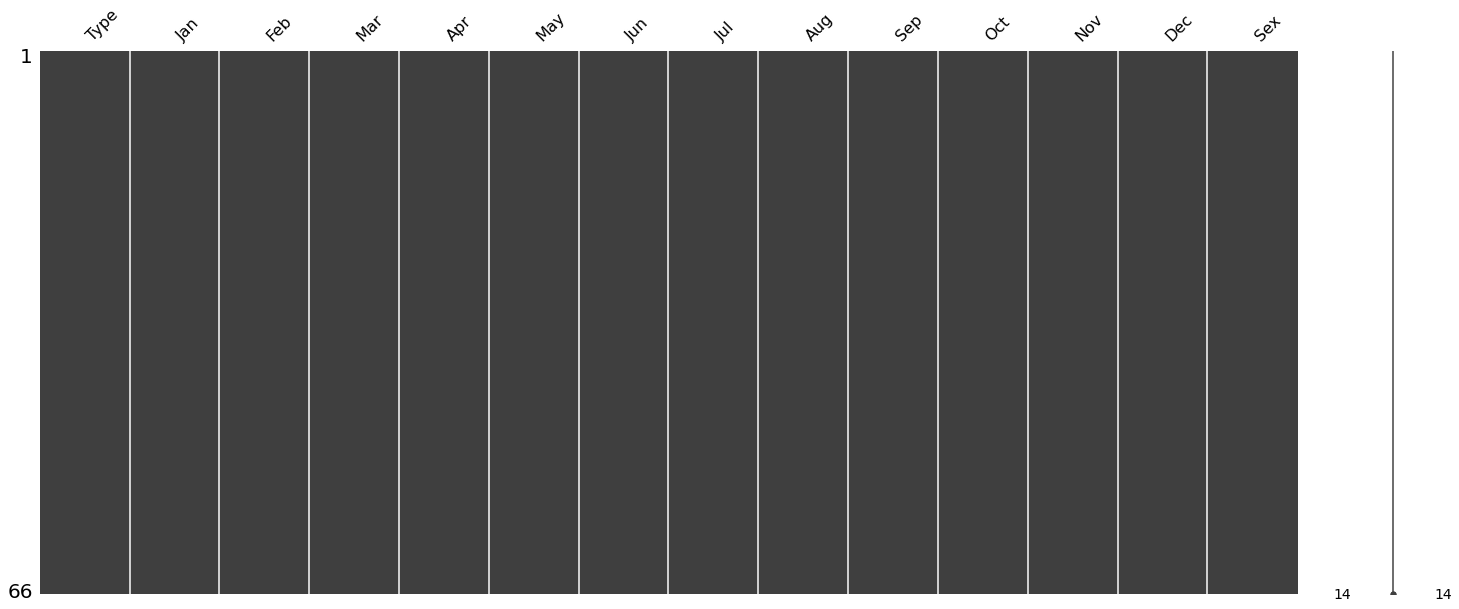

In [46]:
# Check for missing data
miss.matrix(train_X) # None


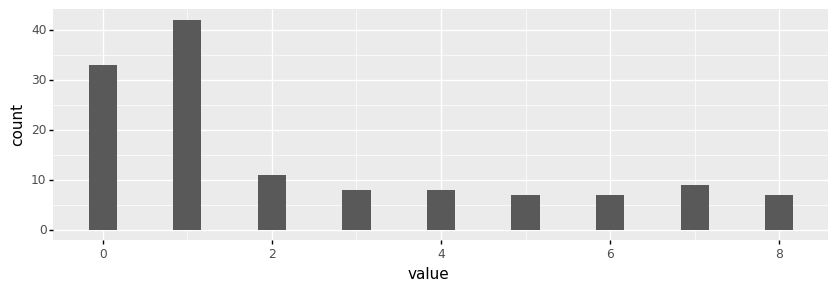

<ggplot: (342456679)>

In [47]:
# Plot the continuous Variables 
d = train_X.select_dtypes(include="int").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

In [48]:
# Create a copy of dat
dat1 = final_df.copy()

<AxesSubplot:>

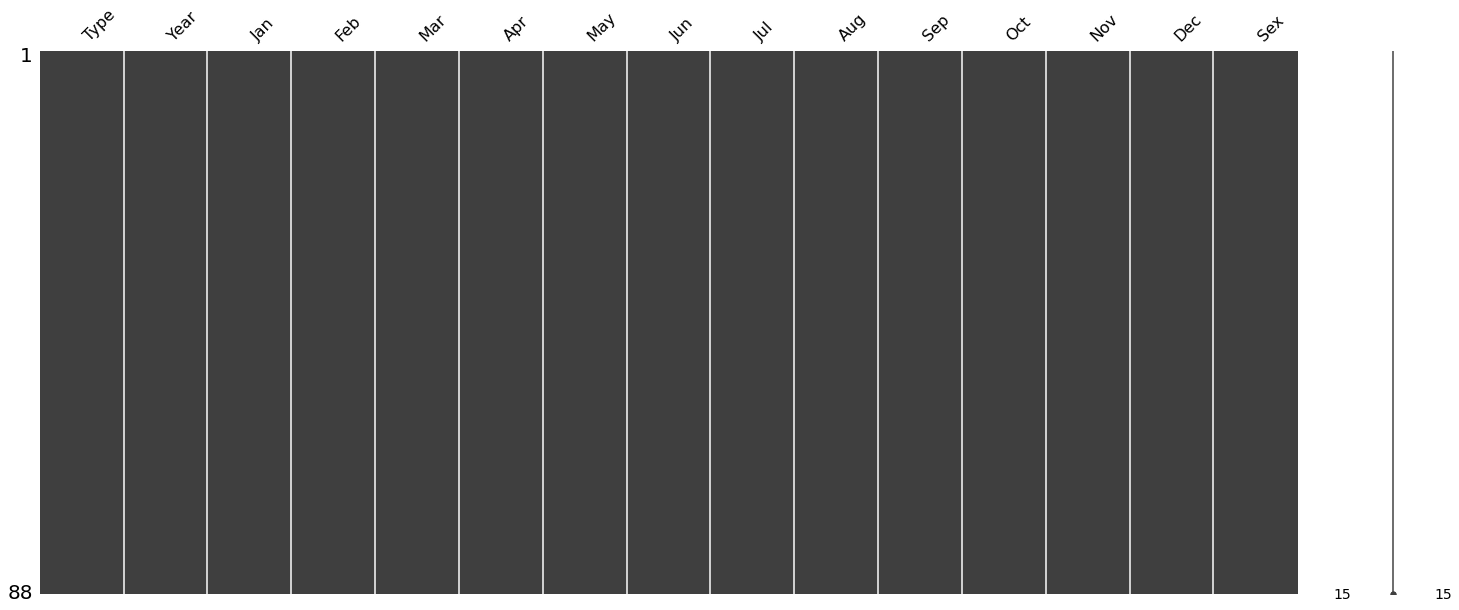

In [49]:
# Check for missing data
miss.matrix(dat1) # None


In [50]:
# Updating some of the items to categories  
for col in ['Type', 'Sex', 'Year']:
    dat1[col] = dat1[col].astype('category')                 

In [51]:
# Find the unique values for each categorical col
for col in ['Type', 'Sex', 'Year']:
  print(dat1[col].unique())

[1, 2, 3, 4, 5, 6, 7, 8]
Categories (8, int64): [1, 2, 3, 4, 5, 6, 7, 8]
[0, 1]
Categories (2, int64): [0, 1]
[2011.0, 2012.0, 2013.0, 2014.0, 2015.0, ..., 2017.0, 2018.0, 2019.0, 2020.0, 2021.0]
Length: 11
Categories (11, float64): [2011.0, 2012.0, 2013.0, 2014.0, ..., 2018.0, 2019.0, 2020.0, 2021.0]


In [52]:
# Create ordered type for Type
Type_cats = [1,2,3,4,5,6,7,8]
Type_types = CategoricalDtype(categories=Type_cats,ordered=True)
dat1[''] = dat1['Type'].astype(Type_types)
dat1['Type'].value_counts()

1    11
2    11
3    11
4    11
5    11
6    11
7    11
8    11
Name: Type, dtype: int64

In [53]:
# Convert categories to counts for Type
dat1['Type'] = dat1['Type'].cat.codes
dat1['Type'].value_counts()

0    11
1    11
2    11
3    11
4    11
5    11
6    11
7    11
Name: Type, dtype: int64

In [54]:
# Create ordered type for Sex
Sex_cats = [0,1]
Sex_types = CategoricalDtype(categories=Sex_cats,ordered=True)
dat1['Sex'] = dat1['Sex'].astype(Sex_types)
dat1['Sex'].value_counts()

0    44
1    44
Name: Sex, dtype: int64

In [55]:
# Convert categories to counts for Sex
dat1['Sex'] = dat1['Sex'].cat.codes
dat1['Sex'].value_counts()

0    44
1    44
Name: Sex, dtype: int64

In [56]:
# Create Ordered type for Year
Year_cats = [2011, 2012, 2013, 2014,2015, 2016, 2017, 2018, 2019, 2020, 2021]
Year_types = CategoricalDtype(categories=Year_cats,ordered=True)
dat1['Year'] = dat1['Year'].astype(Year_types)
dat1['Year'].value_counts()

2011    8
2012    8
2013    8
2014    8
2015    8
2016    8
2017    8
2018    8
2019    8
2020    8
2021    8
Name: Year, dtype: int64

In [57]:
# Convert categories to counts for Marital
dat1['Year'] = dat1['Year'].cat.codes
dat1['Year'].value_counts()

0     8
1     8
2     8
3     8
4     8
5     8
6     8
7     8
8     8
9     8
10    8
Name: Year, dtype: int64

In [58]:
# resplit the data
y = dat1[['Year']]
X = dat1.drop(columns=['Year'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

In [59]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1234)

In [60]:
# Initialize Pipeline
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [61]:
# Set tunig parameters
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]

In [62]:
# Create a grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

In [63]:
search.fit(train_X,train_y.Year)

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/usr/local/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/li

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [64]:
# Best ROC AUC
search.best_score_

nan

In [65]:
rf_mod = search.best_estimator_

In [66]:
# Performance
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])

ValueError: multi_class must be in ('ovo', 'ovr')

In [ ]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=25)

In [ ]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)
vi_dat

,variable,vi,std,low,high
0,Dec,0.104848,0.017628,0.069593,0.140104
1,Mar,0.000606,0.006749,-0.012892,0.014104
2,Jan,0.000000,0.000000,0.000000,0.000000
3,Apr,0.000000,0.000000,0.000000,0.000000
4,May,0.000000,0.000000,0.000000,0.000000
5,Jun,0.000000,0.000000,0.000000,0.000000
6,Jul,0.000000,0.000000,0.000000,0.000000
7,Aug,0.000000,0.000000,0.000000,0.000000
8,Sep,0.000000,0.000000,0.000000,0.000000
9,Oct,0.000000,0.000000,0.000000,0.000000


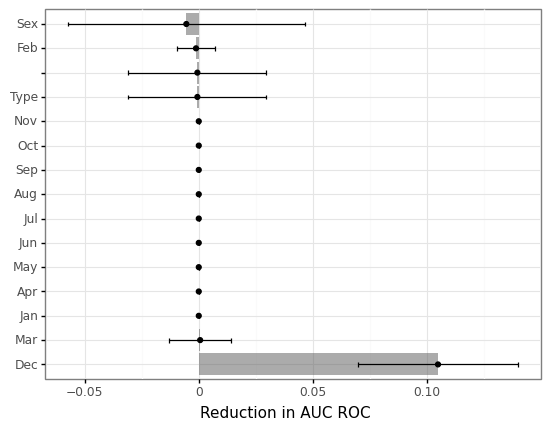

<ggplot: (335997684)>

In [ ]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

ValueError: target must be specified for multi-class

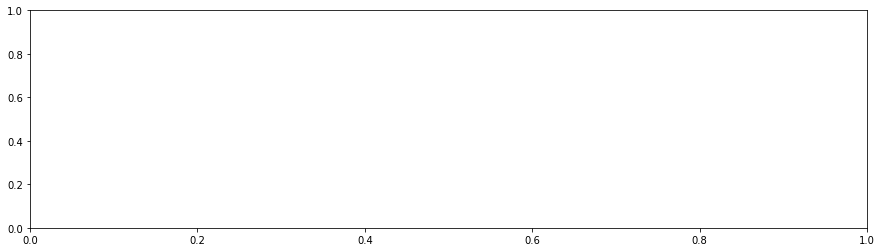

In [ ]:
# Partial Dependency
# Target specific features
features = ['Year','Sex','Type']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(15, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)
# display.figure_.set_figwidth(15)
# display.figure_.set_figheight(4)

ValueError: target must be specified for multi-class

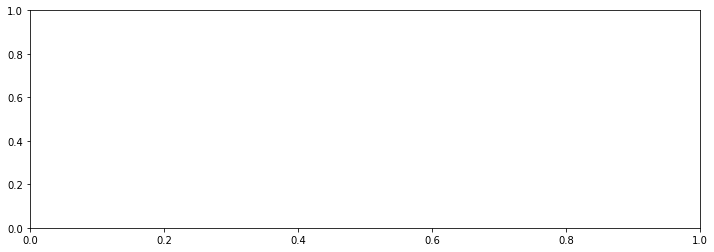

In [ ]:
# Feed in the ineraction as a nested list
interacted_features = [['Type','Sex'],['Type','Year'],['Sex','Year']] 

# Then business as usual when plotting
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod, train_X, interacted_features,
    n_cols=3,n_jobs=4, grid_resolution=20,ax=ax
)
fig.tight_layout()

ValueError: target must be specified for multi-class

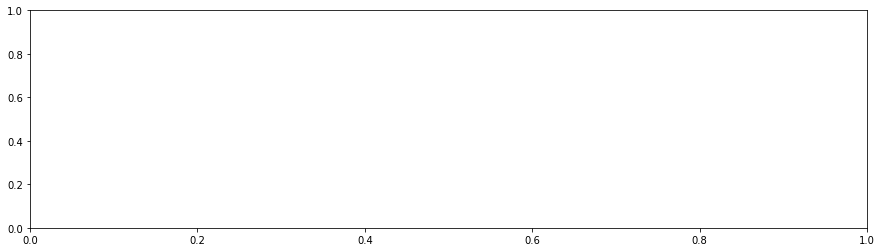

In [ ]:
#ICE Plot
features = ['Type','Sex','Year']
fig, ax = plt.subplots(figsize=(15, 4))
display = PartialDependenceDisplay.from_estimator(
    rf_mod,
    train_X,
    features,
    kind="both", # "average" = just PDP, "individual" = just ICE
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    n_cols=len(features),
    ax = ax
)
display.figure_.subplots_adjust(hspace=0.3)